# Layer.ai Air Quality Prediction Challenge
# By Mohamed Eltayeb

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

In [2]:
#Group Time Series Split
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class GroupTimeSeriesSplit(_BaseKFold):
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [3]:
#Plot the LGBM Features Importances
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

# Read the training and testing data


In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Convert the Tabular Data to Time Series Data

In [5]:
train_df = train_df.sort_values(['date','device']).reset_index(drop=True) 
test_df = test_df.sort_values(['date','device']).reset_index(drop=True)


for dataset in (train_df,test_df):
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['Day'] = dataset.date.dt.day
    dataset['Month'] = dataset.date.dt.month
    dataset['Year'] = dataset.date.dt.year
    dataset['DayOfWeek'] = dataset.date.dt.dayofweek
    dataset['DayOfYear'] = dataset.date.dt.dayofyear
    dataset['Week'] = dataset.date.dt.weekofyear
    dataset.set_index('date', inplace=True)

In [6]:
ID = test_df['ID']
test_df.drop('ID',inplace=True,axis=1)
train_df.drop('ID',inplace=True,axis=1)

# Exploratory data analysis

In [ ]:
train_df.shape

(9923, 75)

In [ ]:
test_df.shape

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9923 entries, 0 to 9922
Data columns (total 71 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID                                                        9923 non-null   object 
 1   date                                                      9923 non-null   object 
 2   device                                                    9923 non-null   object 
 3   site_latitude                                             9923 non-null   float64
 4   site_longitude                                            9923 non-null   float64
 5   humidity                                                  9923 non-null   float64
 6   temp_mean                                                 9903 non-null   float64
 7   SulphurDioxide_SO2_column_number_density                  4291 non-null   float64
 8   SulphurDioxide_SO2

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4254 entries, 2020-08-20 to 2020-12-31
Columns: 248 entries, device to Phi
dtypes: float64(241), int64(7)
memory usage: 8.1 MB


In [ ]:
train_df.head()

,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,Day,Month,Year,DayOfWeek,DayOfYear,Week,SulphurDioxide_SO2_column_number_density_diff_Lag1,SulphurDioxide_SO2_column_number_density_Lag1,SulphurDioxide_SO2_column_number_density_amf_diff_Lag1,SulphurDioxide_SO2_column_number_density_amf_Lag1,SulphurDioxide_SO2_slant_column_number_density_diff_Lag1,SulphurDioxide_SO2_slant_column_number_density_Lag1,SulphurDioxide_cloud_fraction_diff_Lag1,SulphurDioxide_cloud_fraction_Lag1,SulphurDioxide_sensor_azimuth_angle_diff_Lag1,SulphurDioxide_sensor_azimuth_angle_Lag1,SulphurDioxide_sensor_zenith_angle_diff_Lag1,SulphurDioxide_sensor_zenith_angle_Lag1,SulphurDioxide_solar_azimuth_angle_diff_Lag1,SulphurDioxide_solar_azimuth_angle_Lag1,SulphurDioxide_solar_zenith_angle_diff_Lag1,SulphurDioxide_solar_zenith_angle_Lag1,SulphurDioxide_SO2_column_number_density_15km_diff_Lag1,SulphurDioxide_SO2_column_number_density_15km_Lag1,CarbonMonoxide_CO_column_number_density_diff_Lag1,CarbonMonoxide_CO_column_number_density_Lag1,CarbonMonoxide_H2O_column_number_density_diff_Lag1,CarbonMonoxide_H2O_column_number_density_Lag1,CarbonMonoxide_cloud_height_diff_Lag1,CarbonMonoxide_cloud_height_Lag1,CarbonMonoxide_sensor_altitude_diff_Lag1,CarbonMonoxide_sensor_altitude_Lag1,CarbonMonoxide_sensor_azimuth_angle_diff_Lag1,CarbonMonoxide_sensor_azimuth_angle_Lag1,CarbonMonoxide_sensor_zenith_angle_diff_Lag1,CarbonMonoxide_sensor_zenith_angle_Lag1,CarbonMonoxide_solar_azimuth_angle_diff_Lag1,CarbonMonoxide_solar_azimuth_angle_Lag1,CarbonMonoxide_solar_zenith_angle_diff_Lag1,CarbonMonoxide_solar_zenith_angle_Lag1,NitrogenDioxide_NO2_column_number_density_diff_Lag1,NitrogenDioxide_NO2_column_number_density_Lag1,NitrogenDioxide_tropospheric_NO2_column_number_density_diff_Lag1,NitrogenDioxide_tropospheric_NO2_column_number_densit

In [ ]:
test_df.head()

In [ ]:
train_df.describe()

,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,Day,Month,Year,DayOfWeek,DayOfYear,Week,SulphurDioxide_SO2_column_number_density_diff_Lag1,SulphurDioxide_SO2_column_number_density_Lag1,SulphurDioxide_SO2_column_number_density_amf_diff_Lag1,SulphurDioxide_SO2_column_number_density_amf_Lag1,SulphurDioxide_SO2_slant_column_number_density_diff_Lag1,SulphurDioxide_SO2_slant_column_number_density_Lag1,SulphurDioxide_cloud_fraction_diff_Lag1,SulphurDioxide_cloud_fraction_Lag1,SulphurDioxide_sensor_azimuth_angle_diff_Lag1,SulphurDioxide_sensor_azimuth_angle_Lag1,SulphurDioxide_sensor_zenith_angle_diff_Lag1,SulphurDioxide_sensor_zenith_angle_Lag1,SulphurDioxide_solar_azimuth_angle_diff_Lag1,SulphurDioxide_solar_azimuth_angle_Lag1,SulphurDioxide_solar_zenith_angle_diff_Lag1,SulphurDioxide_solar_zenith_angle_Lag1,SulphurDioxide_SO2_column_number_density_15km_diff_Lag1,SulphurDioxide_SO2_column_number_density_15km_Lag1,CarbonMonoxide_CO_column_number_density_diff_Lag1,CarbonMonoxide_CO_column_number_density_Lag1,CarbonMonoxide_H2O_column_number_density_diff_Lag1,CarbonMonoxide_H2O_column_number_density_Lag1,CarbonMonoxide_cloud_height_diff_Lag1,CarbonMonoxide_cloud_height_Lag1,CarbonMonoxide_sensor_altitude_diff_Lag1,CarbonMonoxide_sensor_altitude_Lag1,CarbonMonoxide_sensor_azimuth_angle_diff_Lag1,CarbonMonoxide_sensor_azimuth_angle_Lag1,CarbonMonoxide_sensor_zenith_angle_diff_Lag1,CarbonMonoxide_sensor_zenith_angle_Lag1,CarbonMonoxide_solar_azimuth_angle_diff_Lag1,CarbonMonoxide_solar_azimuth_angle_Lag1,CarbonMonoxide_solar_zenith_angle_diff_Lag1,CarbonMonoxide_solar_zenith_angle_Lag1,NitrogenDioxide_NO2_column_number_density_diff_Lag1,NitrogenDioxide_NO2_column_number_density_Lag1,NitrogenDioxide_tropospheric_NO2_column_number_density_diff_Lag1,NitrogenDioxide_tropospheric_NO2_column_number_density_Lag1,

In [ ]:
test_df.describe()

,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,Day,Month,Year,DayOfWeek,DayOfYear,Week,SulphurDioxide_SO2_column_number_density_diff_Lag1,SulphurDioxide_SO2_column_number_density_Lag1,SulphurDioxide_SO2_column_number_density_amf_diff_Lag1,SulphurDioxide_SO2_column_number_density_amf_Lag1,SulphurDioxide_SO2_slant_column_number_density_diff_Lag1,SulphurDioxide_SO2_slant_column_number_density_Lag1,SulphurDioxide_cloud_fraction_diff_Lag1,SulphurDioxide_cloud_fraction_Lag1,SulphurDioxide_sensor_azimuth_angle_diff_Lag1,SulphurDioxide_sensor_azimuth_angle_Lag1,SulphurDioxide_sensor_zenith_angle_diff_Lag1,SulphurDioxide_sensor_zenith_angle_Lag1,SulphurDioxide_solar_azimuth_angle_diff_Lag1,SulphurDioxide_solar_azimuth_angle_Lag1,SulphurDioxide_solar_zenith_angle_diff_Lag1,SulphurDioxide_solar_zenith_angle_Lag1,SulphurDioxide_SO2_column_number_density_15km_diff_Lag1,SulphurDioxide_SO2_column_number_density_15km_Lag1,CarbonMonoxide_CO_column_number_density_diff_Lag1,CarbonMonoxide_CO_column_number_density_Lag1,CarbonMonoxide_H2O_column_number_density_diff_Lag1,CarbonMonoxide_H2O_column_number_density_Lag1,CarbonMonoxide_cloud_height_diff_Lag1,CarbonMonoxide_cloud_height_Lag1,CarbonMonoxide_sensor_altitude_diff_Lag1,CarbonMonoxide_sensor_altitude_Lag1,CarbonMonoxide_sensor_azimuth_angle_diff_Lag1,CarbonMonoxide_sensor_azimuth_angle_Lag1,CarbonMonoxide_sensor_zenith_angle_diff_Lag1,CarbonMonoxide_sensor_zenith_angle_Lag1,CarbonMonoxide_solar_azimuth_angle_diff_Lag1,CarbonMonoxide_solar_azimuth_angle_Lag1,CarbonMonoxide_solar_zenith_angle_diff_Lag1,CarbonMonoxide_solar_zenith_angle_Lag1,NitrogenDioxide_NO2_column_number_density_diff_Lag1,NitrogenDioxide_NO2_column_number_density_Lag1,NitrogenDioxide_tropospheric_NO2_column_number_density_diff_Lag1,NitrogenDioxide_tropospheric_NO2_column_number_density_Lag1

In [ ]:
#The cardinality of each catgorical feature (Training)
cat_cols = train_df.columns
for col in cat_cols:
    print(col, train_df[col].nunique())

In [ ]:
#The cardinality of each catgorical feature (Testing)
cat_cols = test_df.columns
for col in cat_cols:
    print(col, test_df[col].nunique())

# Plots


In [ ]:
#Target Histogram
train_df['pm2_5'].hist()

In [ ]:
#Numerical Features Histograms (Train)
num_feats = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[num_feats].hist(figsize=(20,15));

In [ ]:
#Numerical Features Histograms (Test)
num_feats = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[num_feats].hist(figsize=(20,15));

# Data Preprocessing

# Missing Data 

In [ ]:
#missing data percentage (Training)
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(60)

In [ ]:
#missing data percentage (Testing)
total = test_df.isnull().sum().sort_values(ascending=False)
percent_1 = test_df.isnull().sum()/test_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

In [7]:
train_df = train_df.bfill().ffill()
test_df = test_df.bfill().ffill()

# Feature Engineering

## Lags for features other than the target 

In [8]:
num_feats = train_df.columns
num_feats = num_feats.drop(['Week','DayOfYear','DayOfWeek','Year','Month','Day','pm2_5','temp_mean','humidity','site_longitude','site_latitude','device'])
def LAG(data,LagFeature,shift=1,NewFeatures=[]) :
    data[NewFeatures[0]]   = data[LagFeature]  - data[LagFeature].shift(shift)
    data[NewFeatures[1]]   = data[LagFeature].shift(shift)
for feature in num_feats:
    LAG(train_df,LagFeature=f'{feature}',shift=1,NewFeatures=[f'{feature}_diff_Lag1',f'{feature}_Lag1'])
    LAG(test_df,LagFeature=f'{feature}',shift=1,NewFeatures=[f'{feature}_diff_Lag1',f'{feature}_Lag1'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


## Combination Between Time Features

In [9]:
for dataset in (train_df,test_df):
    dataset['Year_Month'] = dataset['Year'].astype(str) + '-' + dataset['Month'].astype(str)
    dataset['Year_Week'] = dataset['Year'].astype(str) + '-' + dataset['Week'].astype(str)
    dataset['Year_Month_Day'] = dataset['Year'].astype(str) + '-' + dataset['Month'].astype(str) + '-' + dataset['Day'].astype(str)
    
#Label Encode Them
def label_enc(train_df, test_df, features):
    lbl_enc = LabelEncoder()
    full_data = pd.concat(
        [train_df[features], test_df[features]],
        axis=0)
    for col in (features):
        print(col)
        if train_df[col].dtype == 'object':
            lbl_enc.fit(full_data[col].values)
            train_df[col] = lbl_enc.transform(train_df[col])
            test_df[col] = lbl_enc.transform(test_df[col])
    return train_df, test_df

feats = ['Year_Month','Year_Week','Year_Month_Day']
train_df,test_df = label_enc(train_df,test_df,feats)

Year_Month
Year_Week
Year_Month_Day


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

## Add Aggregations

In [10]:
DevicePM2_5Mean = dict(train_df.groupby('device')['pm2_5'].mean())
DevicePM2_5Std = dict(train_df.groupby('device')['pm2_5'].std())
DevicePM2_5Min = dict(train_df.groupby('device')['pm2_5'].min())
DevicePM2_5Max = dict(train_df.groupby('device')['pm2_5'].max())
for dataset in (train_df,test_df):
    dataset['DevicePM2_5Mean'] = dataset['device'].map(DevicePM2_5Mean)
    dataset['DevicePM2_5Std'] = dataset['device'].map(DevicePM2_5Std)
    dataset['DevicePM2_5Min'] = dataset['device'].map(DevicePM2_5Min)
    dataset['DevicePM2_5Max'] = dataset['device'].map(DevicePM2_5Max)

In [11]:
def Agg(Feature):
    for dataset in (train_df,test_df):
        dataset[f'{Feature}PerMonth'] = dataset['Month'].map(dict(dataset.groupby('Month')[Feature].mean()))
        dataset[f'{Feature}PerWeek'] = dataset['Year_Week'].map(dict(dataset.groupby('Year_Week')[Feature].mean()))
        dataset[f'{Feature}PerDay'] = dataset['Year_Month_Day'].map(dict(dataset.groupby('Year_Month_Day')[Feature].mean()))
        
        dataset[f'{Feature}Month_std'] = dataset['Month'].map(dict(dataset.groupby('Month')[Feature].std()))
        dataset[f'{Feature}Week_std'] = dataset['Year_Week'].map(dict(dataset.groupby('Year_Week')[Feature].std()))
        dataset[f'{Feature}Day_std'] = dataset['Year_Month_Day'].map(dict(dataset.groupby('Year_Month_Day')[Feature].std()))
        
        dataset[f'{Feature}Month_min'] = dataset['Month'].map(dict(dataset.groupby('Month')[Feature].min()))
        dataset[f'{Feature}Week_min'] = dataset['Year_Week'].map(dict(dataset.groupby('Year_Week')[Feature].min()))
        dataset[f'{Feature}Day_min'] = dataset['Year_Month_Day'].map(dict(dataset.groupby('Year_Month_Day')[Feature].min()))
       
        dataset[f'{Feature}Month_max'] = dataset['Month'].map(dict(dataset.groupby('Month')[Feature].max()))
        dataset[f'{Feature}Week_max'] = dataset['Year_Week'].map(dict(dataset.groupby('Year_Week')[Feature].max()))
        dataset[f'{Feature}Day_max'] = dataset['Year_Month_Day'].map(dict(dataset.groupby('Year_Month_Day')[Feature].max()))
        
Agg('temp_mean')
Agg('humidity')
train_df.drop(['Year_Month','Year_Week','Year_Month_Day'],inplace=True,axis=1)
test_df.drop(['Year_Month','Year_Week','Year_Month_Day'],inplace=True,axis=1)

## Rolling for Features other than the Target

In [12]:
def rolling(feature):
    for dataset in (train_df,test_df):
        dataset[f'{feature}_Rolling_3'] = dataset[feature].rolling(3).mean()
        dataset[f'{feature}_Rolling_5'] = dataset[feature].rolling(5).mean()

        dataset[f"{feature}_rolling_mean_60"] = dataset.rolling(60).mean()[feature]
        dataset[f"{feature}_rolling_max_60"] = dataset.rolling(60).max()[feature]
        dataset[f"{feature}_rolling_min_60"] = dataset.rolling(60).min()[feature]

        dataset[f"{feature}_rolling_mean_30"] = dataset.rolling(30).mean()[feature]
        dataset[f"{feature}_rolling_max_30"] = dataset.rolling(30).max()[feature]
        dataset[f"{feature}_rolling_min_30"] = dataset.rolling(30).min()[feature]

        dataset[f"{feature}_rolling_mean_10"] = dataset.rolling(10).mean()[feature]
        dataset[f"{feature}_rolling_max_10"] = dataset.rolling(10).max()[feature]
        dataset[f"{feature}_rolling_min_10"] = dataset.rolling(10).min()[feature]

rolling('temp_mean')
rolling('humidity')

## Polar Coordinates

In [13]:
def cart_to_pol(X,y, a = 0, b = 0): # a and b represnt the center
    r = np.sqrt((X-a)**2 + (y-b)**2)
    phi = np.arctan2((y-a), (X-b))
    return r, phi

train_df['R'], train_df['Phi'] = cart_to_pol(train_df["site_latitude"],train_df["site_longitude"])
test_df['R'], test_df['Phi'] = cart_to_pol(test_df["site_latitude"],test_df["site_longitude"])

## Foureier Frequnecies and Amplitudes  (feat = store, year, month, feature that may have seasonality... etc.)

In [14]:
freq2_dict_no_log = dict()
freq3_dict_no_log = dict()

amp2_dict_no_log = dict()
amp3_dict_no_log = dict()
for feat_1 in ('Year','Month','Day'):
    for feat_2 in ('temp_mean', 'humidity'):
        for i in range(min(train_df[feat_1].unique()), max(train_df[feat_1].unique()) + 1):

            a = train_df.loc[train_df[feat_1]==i]
            a_sales = a[feat_2]

            Y = np.fft.fft(a_sales.values)
            Y = abs(Y)
            freq = np.fft.fftfreq(len(Y), 1)

            intercept_index = np.argmax(Y)
            Y = np.delete(Y, intercept_index)
            freq = np.delete(freq, intercept_index)

            amplitude_1_index = np.argmax(Y)
            amplitude_1 = Y[amplitude_1_index]
            Y = np.delete(Y, amplitude_1_index)
            freq_1 = freq[amplitude_1_index]
            freq = np.delete(freq, amplitude_1_index)

            amplitude_2_index = np.argmax(Y)
            amplitude_2 = Y[amplitude_2_index]
            Y = np.delete(Y, amplitude_2_index)
            freq_2 = freq[amplitude_2_index]
            freq = np.delete(freq, amplitude_2_index)

            amplitude_3_index = np.argmax(Y)
            amplitude_3 = Y[amplitude_3_index]
            Y = np.delete(Y, amplitude_3_index)
            freq_3 = freq[amplitude_3_index]
            freq = np.delete(freq, amplitude_3_index)

            #Freq_1 is not included because it seems as it is always 0
            a[f'Frequency_2_{feat_1}_{feat_2}'] = freq_2
            a[f'Frequency_3_{feat_1}_{feat_2}'] = freq_3

            a[f'Amplitude_2_{feat_1}_{feat_2}'] = amplitude_2
            a[f'Amplitude_3_{feat_1}_{feat_2}'] = amplitude_3


            freq2_dict_no_log[i] = freq_2
            freq3_dict_no_log[i] = freq_3

            amp2_dict_no_log[i] = amplitude_2
            amp3_dict_no_log[i] = amplitude_3


            if i == min(train_df[feat_1].unique()):
                k = a
            else:
                k = pd.concat([k,a])
        train_df = k
        test_df[f'Frequency_2_{feat_1}_{feat_2}'] = test_df[feat_1].map(freq2_dict_no_log)
        test_df[f'Frequency_3_{feat_1}_{feat_2}'] = test_df[feat_1].map(freq3_dict_no_log)
        test_df[f'Amplitude_2_{feat_1}_{feat_2}'] = test_df[feat_1].map(amp2_dict_no_log)
        test_df[f'Amplitude_3_{feat_1}_{feat_2}'] = test_df[feat_1].map(amp3_dict_no_log)
        freq2_dict_no_log = dict()
        freq3_dict_no_log = dict()
        amp2_dict_no_log = dict()
        amp3_dict_no_log = dict()

## Percentage change in Feature during the past 2 Weeks, One Month, 3 Months.


In [15]:
periods = [1, 3, 7, 14]
return_names = []
for period in periods:
    return_names.append(f"return_{period}")
    train_df.loc[:, f"PctChangeTemp_{period}"] = train_df["temp_mean"].pct_change(period)
    train_df.loc[:, f"PctChangeHumi_{period}"] = train_df["humidity"].pct_change(period)
    test_df.loc[:, f"PctChangeTemp_{period}"] = test_df["temp_mean"].pct_change(period)
    test_df.loc[:, f"PctChangeHumi_{period}"] = test_df["humidity"].pct_change(period)

## Historic Volatility

In [16]:
periods = [3, 7, 14]
for period in periods:
    train_df.loc[:, f"volatility_temp_mean_{period}"] = train_df["temp_mean"].diff().rolling(period).std()
    test_df.loc[:, f"volatility_temp_mean_{period}"] = test_df["temp_mean"].diff().rolling(period).std()
    train_df.loc[:, f"volatility_humidity_{period}"] = train_df["humidity"].diff().rolling(period).std()
    test_df.loc[:, f"volatility_humidity_{period}"] = test_df["humidity"].diff().rolling(period).std()

# Encoding

In [17]:
def label_enc(train_df, test_df, features):
    lbl_enc = LabelEncoder()
    full_data = pd.concat([train_df[features], test_df[features]], axis=0)
    
    for col in (features):
        print(col)
        lbl_enc.fit(full_data[col].values)
        train_df[col] = lbl_enc.transform(train_df[col])
        test_df[col] = lbl_enc.transform(test_df[col])
    return train_df, test_df

train_df, test_df = label_enc(train_df,test_df,['device'])

device


# Modeling

In [18]:
from catboost import CatBoostRegressor
params = {'n_estimators': 2064, 'learning_rate': 0.03196897706232692, 'depth': 5, 'reg_lambda': 12.680808984686983}
cb = CatBoostRegressor(**params,verbose=0, random_state=42)
LOGcb = TransformedTargetRegressor(cb, func = np.log1p, inverse_func = np.expm1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [19]:
print('Validating...')

Means = [20.772597188397544]
STDs = [2.2423317130434035]

X = train_df.drop('pm2_5',axis=1).values
y = train_df['pm2_5'].values

temp = train_df.copy()
temp['date'] = temp.index
temp = temp.reset_index(drop=True)

scores = []
for train_index, test_index in GroupTimeSeriesSplit(n_splits=4).split(X, y, groups=temp['date'].values):
    X_Train, X_Test = X[train_index], X[test_index]
    y_Train, y_Test = y[train_index], y[test_index]
    LOGcb.fit(X_Train,y_Train)
    vali = temp.loc[(temp.index >= test_index[0]) & (temp.index <= test_index[-1])]
    y_pred = LOGcb.predict(X_Test)
    scores.append(mean_absolute_error(y_pred,y_Test))
    print(scores[-1])
    
print("\nMean:",np.mean(scores),"\nSTD: ", np.std(scores))
Means.append(np.mean(scores))
STDs.append(np.std(scores))

if (Means[-1] < Means[-2]):
    print('Better')
elif (Means[-1] > Means[-2]):
    print('Worse')
else:
    print('Same')

if (STDs[-1] > STDs[-2]):
    print('Worse')
elif (STDs[-1] < STDs[-2]):
    print('Better')
else:
    print('Same')
    
#Current
# 22.35697296766639
# 19.633541768174815
# 23.396457435106985
# 17.703416582641996

# Mean: 20.772597188397544 
# STD:  2.2423317130434035

#Add Aggs
# 20.29906018632147
# 19.40011030425418
# 21.489481435399824
# 15.553547705530448

# Mean: 19.18554990787648 
# STD:  2.2240437150188206

#Add temp and humi aggs, lag1 and diffLag1, iterations 1500 
# 20.607747367647885
# 19.004941591271976
# 19.662464144732017
# 15.319994264465363

# Mean: 18.64878684202931 
# STD:  2.0045432300651047

#All features, bfill
# 20.96838789431987
# 19.522345560865634
# 19.732901245314444
# 14.763895417143129

# Mean: 18.74688252941077 
# STD:  2.3649972644844404

#All Features, bfill, added polar coordinates
# 20.91392554384148
# 19.469829786904235
# 19.71329677465141
# 14.654767798518758

# Mean: 18.687954975978972 
# STD:  2.3918715371798225

#Added Fourier
# 18.17240386470159
# 17.77781424195895
# 16.46037071101939
# 17.940171304996845

# Mean: 17.587690030669194 
# STD:  0.6657945217247504

#Added pct_change
# 18.175277583088164
# 17.732709187259236
# 16.5081661954672
# 17.890815439422155

# Mean: 17.57674210130919 
# STD:  0.6369982305916528

#Label Encoder not factorize
# 18.1618216212581
# 17.70123766840608
# 16.447129911428416
# 17.882858499710284

# Mean: 17.54826192520072 
# STD:  0.6565637170265808

#Historic volatility
# 18.128184004941573
# 17.709482399686724
# 16.41483446374955
# 17.856203544286508

# Mean: 17.527176103166088 
# STD:  0.6595470156739709

#Log Catboost then Exp
# 17.326830967173596
# 16.341625157851414
# 16.415704984933168
# 17.30049091528574

# Mean: 16.846163006310977 
# STD:  0.4683236290669921

#Bfill.ffill before feature enginnering
# 17.19861511307665
# 16.206888223630234
# 15.73748659143138
# 16.7823211397728

# Mean: 16.481327766977767 
# STD:  0.5553635981794134

#Added Aggs mean of target based on device
# 16.53056494289137
# 15.69327004634034
# 15.10131569564171
# 16.218698803132693

# Mean: 15.88596237200153 
# STD:  0.5429149901436979

#added mean,std,min,max of target
# 16.47127157015698
# 15.58906290095826
# 15.038922248552824
# 16.161902448642376

# Mean: 15.81528979207761 
# STD:  0.5487206930140535

#Params Trial 15
# 15.506035440162002
# 13.800118449113926
# 12.445266966704509
# 13.943131111023071

# Mean: 13.923637991750876 
# STD:  1.0845736064863105

Validating...
15.396345769312855
13.974316023939913
12.863882488917168


KeyboardInterrupt: ignored

## Show the Features Importances 

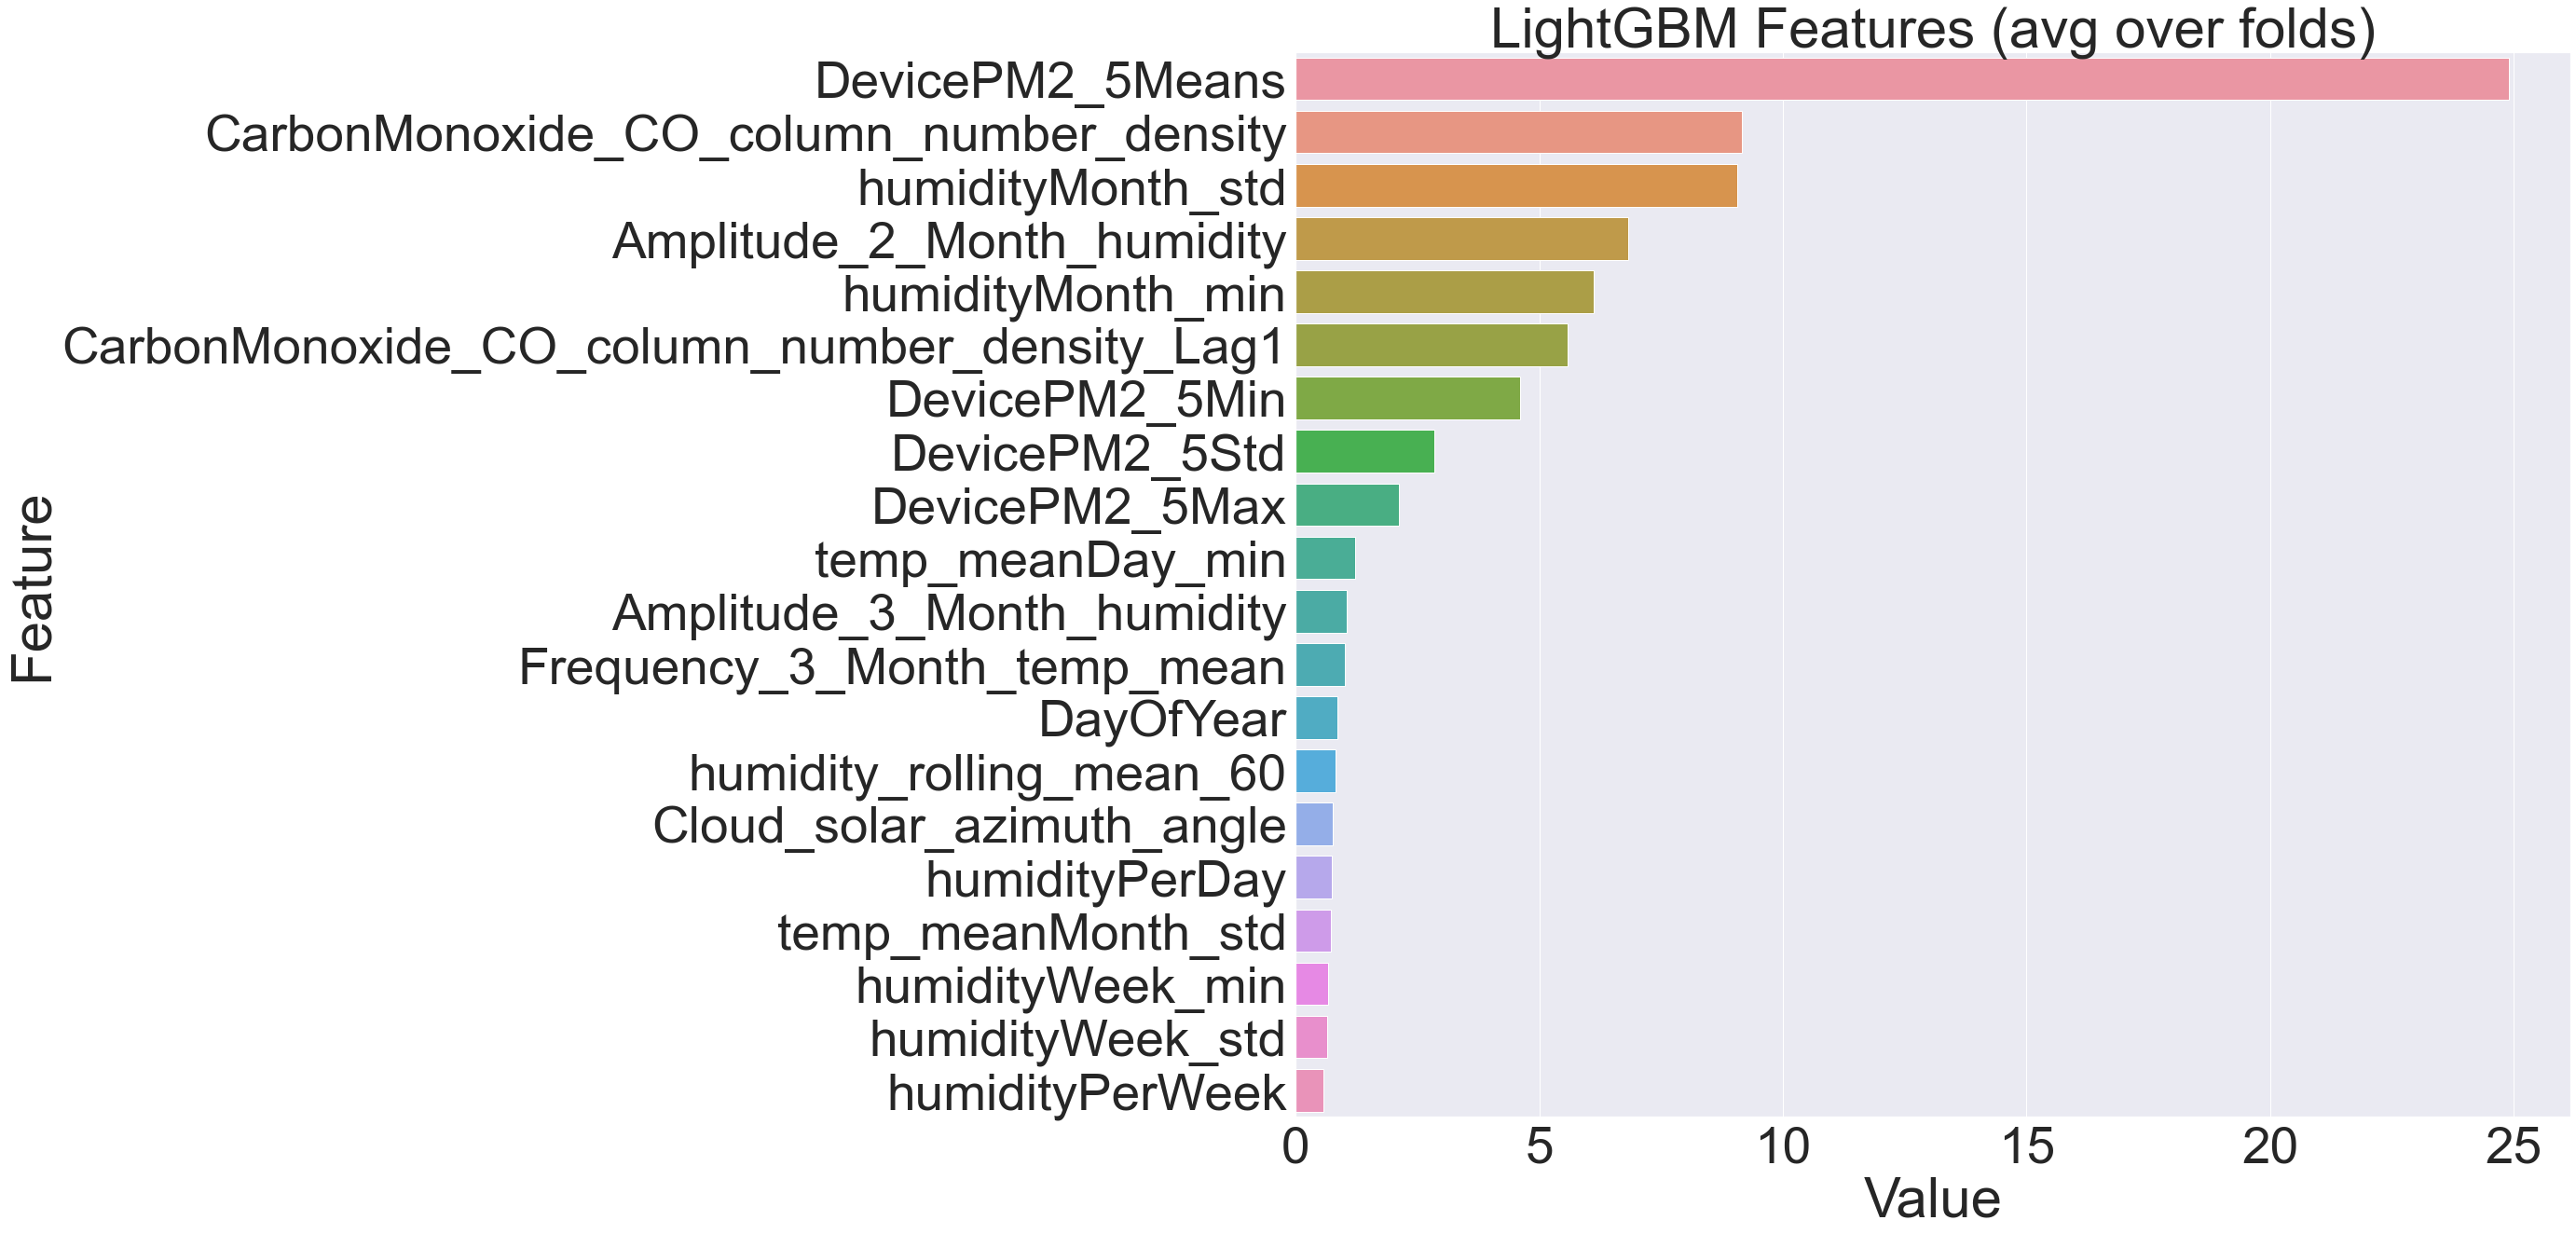

In [ ]:
cb.fit(X,y)
plotImp(cb,train_df.drop('pm2_5',axis=1))

In [20]:
Predictions = pd.DataFrame()
X = train_df.drop('pm2_5',axis=1)
y = train_df['pm2_5']

for seed in range(20,46):
    print(f'Seed: {seed}')
    params = {'n_estimators': 2064, 'learning_rate': 0.03196897706232692, 'depth': 5, 'reg_lambda': 12.680808984686983}
    cb = CatBoostRegressor(**params,verbose=0, random_state=seed, task_type = 'GPU')
    LOGcb = TransformedTargetRegressor(cb, func = np.log1p, inverse_func = np.expm1)  
    LOGcb.fit(X, y)

    Predictions[f'Target_{seed}'] = LOGcb.predict(test_df)
    Predictions[f'Target_{seed}'] = Predictions[f'Target_{seed}'] * 1.015  #Change to 0.975 to get best in LB
Predictions['Mean'] = Predictions.mean(axis=1)
Predictions['HMean'] = Predictions.apply(stats.hmean, axis=1)
Predictions['GMean'] = Predictions.apply(stats.gmean, axis=1)

Seed: 35
Seed: 36
Seed: 37
Seed: 38
Seed: 39
Seed: 40
Seed: 41
Seed: 42
Seed: 43
Seed: 44
Seed: 45


In [23]:
FinalPred = Predictions[['Mean','HMean','GMean']].apply(stats.hmean,axis=1)

In [24]:
submission = pd.DataFrame({"Id": ID ,"pm2_5": FinalPred.values})
submission.to_csv('Best2 - Seed 20 - 46 - Hmean- Correction1015.csv',index=False)